# Graph 3D for IoU

Set below the list of tuples of parameters ($\mu_1, \sigma_1, \mu_2, \sigma_2$), with $\mu_1 \leq \mu_2$.

*Note: you can generate it with 'geometric_succession_generator.py'.*

In [1]:
parameters_list = [(122, 50, 134, 50),
                   (115, 50, 141, 50),
                   (100, 50, 156, 50),
                   (68,  50, 188, 50),
                   (1,   50, 255, 50),
                   ]
                   

Initialize some parameters:

In [2]:
epochs = 1
classes = 2
n = len(parameters_list)
mus_differences = [mu2 - mu1 for mu1, sigma1, mu2, sigma2 in parameters_list]

The above parameters_list will generate datasets like these:

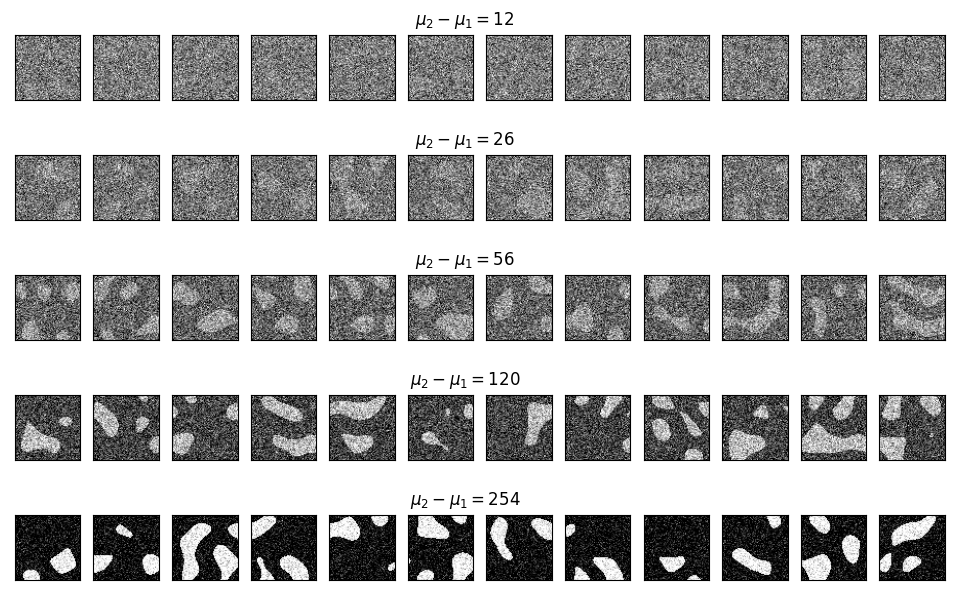

In [3]:
from functions import perlin_shapes_show_sample

perlin_shapes_show_sample(12, parameters_list, mus_differences)

***Quick explaination on the dataset generation -***
*A 64x64 perlin noise matrix is generated. For each entry, if the absolute value is greater than a threshold, we define it as 1 (white), otherwise as 0 (black). Then, a random normal white noise with mean $\mu_1$ and std $\sigma_1$ takes the place of the 0's, while a random normal white noise with mean $\mu_2$ and std $\sigma_2$ takes the place of the 1's.*

## STEP 1: Create datasets

In [4]:
from functions import print_step, remove_directory

###############################
### STEP 1: CREATE DATASETS ###
###############################
print_step(1,"Creating datasets")

from functions import perlin_shapes
from tqdm import tqdm

# remove directory data_toydataset (if already exists)
if not remove_directory('data_toydataset', ask=True, notify=True):
    raise AssertionError("The folder data_toydataset already exists and may contain files, the algorithm may not work correctly. Remove the directory to continue")

# create datasets
for i,parameters in enumerate(tqdm(parameters_list, disable = False)):
    perlin_shapes(folder = f'data_toydataset/data{i}/', n_img = 1000, parameters = parameters, verbose = False)


> STEP 1 - 	Creating datasets

The folder "data_toydataset" was removed!



100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


## STEP 2: save image with samples


> STEP 2 - 	Saving 'samples.png'


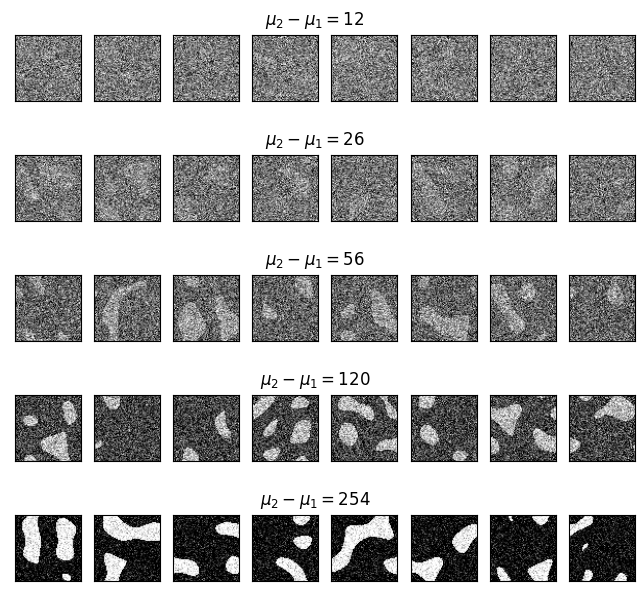

In [5]:
#######################################
### STEP 2: SAVE IMAGE WITH SAMPLES ###
#######################################
print_step(2,"Saving 'samples.png'")

import matplotlib.pyplot as plt
from matplotlib import rcParams, rcParamsDefault
from PIL import Image

n_rows = n
n_cols = 8 # you can change this

rcParams['figure.figsize'] = n_cols, n_rows*1.2 # set image width and height
fig, axs = plt.subplots(n_rows,n_cols)

subfigs = fig.subfigures(nrows=n_rows, ncols=1)
for i, subfig in enumerate(subfigs):
    subfig.suptitle(f'$\mu_2 - \mu_1 = {mus_differences[i]}$')
    axs = subfig.subplots(nrows=1, ncols=n_cols)
    for j, ax in enumerate(axs):
        image = Image.open(f'data_toydataset/data{i}/img/{j}.png')
        ax.imshow(image)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]) # remove ticks

plt.savefig('data_toydataset/samples.png')

plt.show()

rcParams.update(rcParamsDefault) # reset parameters

#   STEP 3: train, predict, IoU

Here we train a Unet on each dataset, we save the model (MODEL0.pth MODEL1.pth ecc) and we use it to generate the predicted mask on all datasets, and finally we compute all the IoUs and save them in the file graph_3d.txt

In [6]:
from functions import print_step

###################################
### STEP 3: TRAIN, PREDICT, IOU ###
###################################
print_step(3,"training, prediction and IoU")

from train import train
from pathlib import Path
from predict import predict
from os import listdir, rename
from os.path import join
from functions import IoU, avg_IoU, create_directories
from tqdm import tqdm

d = {}

with tqdm(total = n*n) as pbar:
    for i in range(n):
        train_img =         f'./data_toydataset/data{i}/img/'
        train_mask =        f'./data_toydataset/data{i}/label/'
        train_checkpoint =  f'./data_toydataset/data{i}/'

        print(f'training\t({i+1}/{n})')

        train(Path(train_img),
            Path(train_mask),
            Path(train_checkpoint),
            epochs = epochs,
            amp = True,
            classes = classes)

        rename(f'data_toydataset/data{i}/checkpoint_epoch{epochs}.pth',f'data_toydataset/data{i}/MODEL{i}.pth')
        
        print(f'predicting\t({i+1}/{n})')

        for j in range(n):
            pred_input =        f'data_toydataset/data{j}/img/'
            pred_output =       f'data_toydataset/data{j}/pred{i}/'
            true_masks =        f'data_toydataset/data{j}/label/'

            pred_input_files  = sorted([join(pred_input,  file) for file in listdir(pred_input)])
            pred_output_files = sorted([join(pred_output, file) for file in listdir(pred_input)])

            create_directories(pred_output, verbose = False)

            predict(input = pred_input_files,
                    output = pred_output_files,
                    model = f"data_toydataset/data{i}/MODEL{i}.pth",
                    classes = classes
                    )

            pbar.update(1)

            v = avg_IoU(pred_output, true_masks, True)/2 + avg_IoU(pred_output, true_masks, False)/2
            d[(i,j)] = v

with open('data_toydataset/graph_3d.txt','w') as graph_3d:
    graph_3d.write(str(d))



> STEP 3 - 	training, prediction and IoU


  0%|          | 0/25 [00:00<?, ?it/s]

training	(1/5)


predicting	(1/5)


 20%|██        | 5/25 [01:21<03:56, 11.85s/it]

training	(2/5)


predicting	(2/5)


 40%|████      | 10/25 [02:41<02:59, 11.97s/it]

training	(3/5)


predicting	(3/5)


 60%|██████    | 15/25 [04:02<01:59, 11.98s/it]

training	(4/5)


predicting	(4/5)


 80%|████████  | 20/25 [05:22<00:59, 11.80s/it]

training	(5/5)


predicting	(5/5)


100%|██████████| 25/25 [06:42<00:00, 16.10s/it]


# STEP 4: graph 3D

We use the dictionary 'd' from the above code to generate the 3D graph below ('d' is also printed in graph_3d.txt).


> STEP 4 - 	creating 'graph_3d.png'


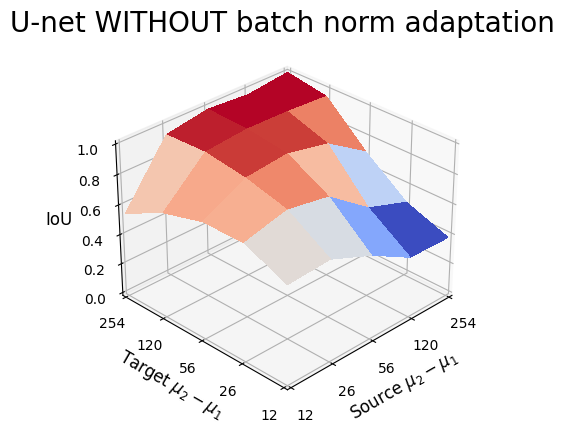

In [7]:
########################
### STEP 4: GRAPH 3D ###
########################
print_step(4, "creating 'graph_3d.png'")

from functions import graph_3d

graph_3d(d, mus_differences, filename = 'graph_3d', title = 'U-net WITHOUT batch norm adaptation', show = True)

## STEP 5: BN adaptation

We take all models (MODEL0.pth MODEL1.pth ecc), apply the BN adaptation for each to all datasets and save them (MODEL00.pth MODEL01.pth MODEL02.pth ... MODEL10.pth ecc...), we make the prediciton on the adapted dataset, compute the IoU, and finally save all IoUs under graph_3d_adapted.txt .

In [8]:
#############################
### STEP 5: BN ADAPTATION ###
#############################
print_step(5, "Applying the BN adaptation, predicting and saving the IoU")

from tqdm import tqdm
from os import cpu_count, listdir
from os.path import join
from utils.data_loading import BasicDataset
from torch.utils.data import DataLoader
from functions import BN_adapt, create_directories, avg_IoU
from itertools import product
from predict import predict

batch_size = 1

create_directories('data_toydataset/MODELS_adapted/')

ij_list = list(product(range(n), repeat = 2)) # this is just so tqdm scrolls through all the iterations

d_adapted = {}

for i,j in tqdm(ij_list):

    original_model =    f'data_toydataset/data{i}/MODEL{i}.pth'
    pred_input =        f'data_toydataset/data{j}/img/'
    true_masks =        f'data_toydataset/data{j}/label/'
    adapted_model =     f'data_toydataset/MODELS_adapted/MODEL{i}{j}.pth'

    dataset = BasicDataset(pred_input, true_masks, scale=1.0)
    loader_args = dict(batch_size=batch_size, num_workers=cpu_count(), pin_memory=True)
    dataset_loader = DataLoader(dataset, shuffle=True, **loader_args)
    BN_adapt(original_model, dataset_loader, 'cuda', adapted_model)

    pred_output =       f'data_toydataset/data{j}/pred_adapted{i}/'
    pred_input_files  = sorted([join(pred_input,  file) for file in listdir(pred_input)])
    pred_output_files = sorted([join(pred_output, file) for file in listdir(pred_input)])

    create_directories(pred_output, verbose = False)

    predict(input = pred_input_files,
            output = pred_output_files,
            model = f"data_toydataset/MODELS_adapted/MODEL{i}{j}.pth",
            classes = classes
            )

    v = avg_IoU(pred_output, true_masks, True)/2 + avg_IoU(pred_output, true_masks, False)/2
    d_adapted[(i,j)] = v

with open('data_toydataset/graph_3d_adapted.txt','w') as graph_me_adapted:
    graph_me_adapted.write(str(d_adapted))


> STEP 5 - 	Applying the BN adaptation, predicting and saving the IoU
created folder data_toydataset/MODELS_adapted/


100%|██████████| 25/25 [08:04<00:00, 19.36s/it]


## STEP 6: graph 3d (adapted)

We plot the graph 3d for the BN adapted models.


> STEP 6 - 	creating 'graph_3d_adapted.png'


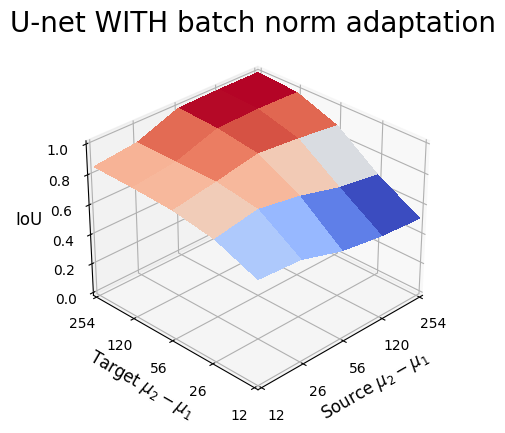

In [9]:
##################################
### STEP 6: GRAPH 3D (ADAPTED) ###
##################################
print_step(6, "creating 'graph_3d_adapted.png'")

from functions import graph_3d
graph_3d(d_adapted, mus_differences, filename = 'graph_3d_adapted', title = 'U-net WITH batch norm adaptation', show = True)

## STEP 7: graph 3d (difference)

We plot the 3d graph of the difference between the two graphs. The points with red dots are the points where the adaptation made the prediction worse.


> STEP 7 - 	creating 'graph_3d_difference.png'


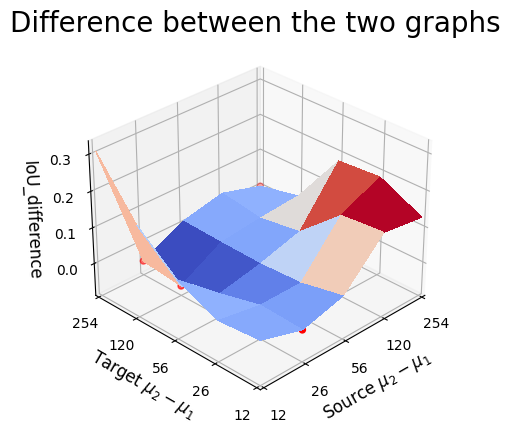

In [10]:
#####################################
### STEP 7: GRAPH 3D (DIFFERENCE) ###
#####################################
print_step(7, "creating 'graph_3d_difference.png'")

d_diff = {key:d_adapted[key]-d[key] for key in d}

with open('data_toydataset/graph_3d_diff.txt','w') as graph_me_diff:
    graph_me_diff.write(str(d_diff))

from functions import graph_3d

graph_3d(d_diff, mus_differences, filename = 'graph_3d_diff', title = 'Difference between the two graphs', show = True, is_diff = True)
